## 1️⃣ Import Libraries & Setup

In [2]:
# Core libraries
import os
import sys
from pathlib import Path
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Computer Vision
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics & Visualization
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ All libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 6GB Laptop GPU


## 2️⃣ Setup Paths & Configuration

In [3]:
# Add src to path
sys.path.insert(0, str(Path.cwd() / 'src'))

# Import custom modules
from utils.config_loader import load_config
from models.cnn_facenet import create_model

# Load configuration
config = load_config('config.yaml')

# Setup paths
TEST_DIR = Path('Test')  # Test dataset directory
MODELS_DIR = Path(config['paths']['models_dir'])
OUTPUT_DIR = Path('test_results')
OUTPUT_DIR.mkdir(exist_ok=True)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("\n" + "="*60)
print("Configuration")
print("="*60)
print(f"Test Directory: {TEST_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Device: {device}")
print("="*60)


Configuration
Test Directory: Test
Models Directory: models
Output Directory: test_results
Device: cuda


## 🔍 CUDA Diagnostic Check

In [4]:
print("="*70)
print("🔍 CUDA DIAGNOSTIC CHECK")
print("="*70)

# Check CUDA availability
print(f"\n1. CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"2. CUDA Version: {torch.version.cuda}")
    print(f"3. Current Device: {torch.cuda.current_device()}")
    print(f"4. Device Name: {torch.cuda.get_device_name(0)}")
    print(f"5. Device Count: {torch.cuda.device_count()}")
    print(f"6. Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"7. Memory Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    
    # Test CUDA with simple operation
    print("\n8. Testing CUDA with simple tensor operation...")
    test_tensor = torch.randn(1000, 1000).cuda()
    result = test_tensor @ test_tensor.t()
    print(f"   ✓ CUDA computation successful! Result shape: {result.shape}")
    
    del test_tensor, result
    torch.cuda.empty_cache()
    print("   ✓ Memory cleared")
else:
    print("\n⚠️ WARNING: CUDA is NOT available!")
    print("   Running on CPU - this will be VERY SLOW")
    print("\nPossible solutions:")
    print("   1. Install CUDA-enabled PyTorch: pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118")
    print("   2. Check NVIDIA driver installation")
    print("   3. Verify GPU is properly connected")

print("="*70)

🔍 CUDA DIAGNOSTIC CHECK

1. CUDA Available: True
2. CUDA Version: 11.8
3. Current Device: 0
4. Device Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
5. Device Count: 1
6. Memory Allocated: 0.00 GB
7. Memory Cached: 0.00 GB

8. Testing CUDA with simple tensor operation...
   ✓ CUDA computation successful! Result shape: torch.Size([1000, 1000])
   ✓ Memory cleared
   ✓ CUDA computation successful! Result shape: torch.Size([1000, 1000])
   ✓ Memory cleared


## 3️⃣ Load Test Dataset

In [5]:
# Install required libraries for image format conversion if not already installed
try:
    from PIL import Image
    import pillow_heif
    pillow_heif.register_heif_opener()
    print("✓ HEIF/HEIC support enabled")
except ImportError:
    print("⚠️ pillow-heif not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pillow-heif"])
    import pillow_heif
    pillow_heif.register_heif_opener()
    print("✓ HEIF/HEIC support installed and enabled")

✓ HEIF/HEIC support enabled


In [6]:
class TestDataset(Dataset):
    """Custom dataset untuk test data dari folder /Test dengan konversi format otomatis"""
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        # Support berbagai format gambar termasuk HEIC dan WEBP
        self.image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.webp', '.heic', '.heif', '.tiff', '.tif'}
        
        # Find all classes (student folders)
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        # Build dataset dan track format gambar
        self.samples = []
        format_counter = {}
        
        for class_name, class_idx in self.class_to_idx.items():
            class_dir = self.root_dir / class_name
            for img_path in class_dir.iterdir():
                ext = img_path.suffix.lower()
                if ext in self.image_extensions:
                    self.samples.append((img_path, class_idx))
                    format_counter[ext] = format_counter.get(ext, 0) + 1
        
        print(f"✓ Dataset loaded: {len(self.samples)} images, {len(self.classes)} classes")
        print(f"\n📊 Image format distribution:")
        for ext, count in sorted(format_counter.items()):
            print(f"   {ext}: {count} images")
    
    def __len__(self):
        return len(self.samples)
    
    def load_image_safe(self, img_path):
        """
        Load image dengan handling berbagai format (HEIC, WEBP, dll)
        Returns: numpy array RGB
        """
        try:
            ext = img_path.suffix.lower()
            
            # Untuk format khusus (HEIC, WEBP), gunakan PIL
            if ext in {'.heic', '.heif', '.webp', '.tiff', '.tif'}:
                try:
                    # Buka dengan PIL
                    pil_image = Image.open(img_path)
                    
                    # Convert ke RGB jika perlu
                    if pil_image.mode != 'RGB':
                        pil_image = pil_image.convert('RGB')
                    
                    # Convert PIL to numpy array
                    image = np.array(pil_image)
                    return image
                    
                except Exception as e:
                    print(f"⚠️ PIL failed for {img_path.name}: {e}, trying OpenCV...")
            
            # Default: gunakan OpenCV untuk format standar
            image = cv2.imread(str(img_path))
            if image is None:
                # Jika OpenCV gagal, coba PIL sebagai fallback
                try:
                    pil_image = Image.open(img_path).convert('RGB')
                    image = np.array(pil_image)
                    return image
                except:
                    print(f"❌ Failed to load: {img_path.name}")
                    return None
            else:
                # OpenCV returns BGR, convert to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                return image
                
        except Exception as e:
            print(f"❌ Error loading {img_path.name}: {e}")
            return None
    
    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        
        # Load image dengan handling format yang aman
        image = self.load_image_safe(img_path)
        
        # Jika gagal load, gunakan placeholder
        if image is None:
            print(f"⚠️ Using placeholder for {img_path.name}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        
        # Apply transform
        if self.transform:
            try:
                augmented = self.transform(image=image)
                image = augmented['image']
            except Exception as e:
                print(f"⚠️ Transform failed for {img_path.name}: {e}")
                # Fallback: resize manual dan normalize
                image = cv2.resize(image, (224, 224))
                image = image.astype(np.float32) / 255.0
                image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
                image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        
        return image, class_idx

# Create test transform (no augmentation)
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0
    ),
    ToTensorV2()
])

# Load test dataset
print("Loading test dataset with format conversion support...\n")
test_dataset = TestDataset(TEST_DIR, transform=test_transform)

# FIX: Set num_workers=0 to avoid Windows multiprocessing issues
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,  # Changed from 4 to 0 - fixes hanging on Windows
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✓ Test DataLoader created")
print(f"  Total batches: {len(test_loader)}")
print(f"  Batch size: 32")
print(f"  Workers: 0 (Windows-safe)")
print(f"  Format support: JPG, PNG, BMP, WEBP, HEIC, HEIF, TIFF")
print(f"\nClass names (first 10): {test_dataset.classes[:10]}")

Loading test dataset with format conversion support...

✓ Dataset loaded: 71 images, 70 classes

📊 Image format distribution:
   .jpeg: 16 images
   .jpg: 54 images
   .png: 1 images

✓ Test DataLoader created
  Total batches: 3
  Batch size: 32
  Workers: 0 (Windows-safe)
  Format support: JPG, PNG, BMP, WEBP, HEIC, HEIF, TIFF

Class names (first 10): ['Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar', 'Alief Fathur Rahman', 'Arkan Hariz Chandrawinata Liem', 'Bayu Ega Ferdana', 'Bayu Prameswara Haris', 'Bezalel Samuel Manik']


## 🔍 Verify Image Loading (Sample Test)

In [7]:
print("Testing image loading from different formats...\n")

# Test loading beberapa sample images
num_test_samples = min(5, len(test_dataset))
failed_loads = []
successful_loads = []

for i in range(num_test_samples):
    try:
        img, label = test_dataset[i]
        img_path, _ = test_dataset.samples[i]
        
        # Check if image loaded properly
        if isinstance(img, torch.Tensor) and img.shape == torch.Size([3, 224, 224]):
            successful_loads.append(img_path.name)
            print(f"✓ Sample {i+1}: {img_path.name} ({img_path.suffix}) - Shape: {img.shape}, Label: {test_dataset.classes[label]}")
        else:
            failed_loads.append(img_path.name)
            print(f"⚠️ Sample {i+1}: {img_path.name} - Invalid shape: {img.shape}")
            
    except Exception as e:
        img_path, _ = test_dataset.samples[i]
        failed_loads.append(img_path.name)
        print(f"❌ Sample {i+1}: {img_path.name} - Error: {e}")

print("\n" + "="*60)
print("📊 LOADING TEST SUMMARY")
print("="*60)
print(f"Successful loads: {len(successful_loads)}/{num_test_samples}")
print(f"Failed loads:     {len(failed_loads)}/{num_test_samples}")

if failed_loads:
    print(f"\n⚠️ Failed files: {', '.join(failed_loads)}")
else:
    print("\n✅ All sample images loaded successfully!")
print("="*60)

Testing image loading from different formats...

✓ Sample 1: IMG_2138 - Abraham Ganda Napitu.jpeg (.jpeg) - Shape: torch.Size([3, 224, 224]), Label: Abraham Ganda Napitu
✓ Sample 2: 1 - I22I4OI64_ ABU BAKAR SIDDIQ SIREGAR.jpeg (.jpeg) - Shape: torch.Size([3, 224, 224]), Label: Abu Bakar Siddiq Siregar
✓ Sample 3: Ahmad Faqih Hasani_1.jpg (.jpg) - Shape: torch.Size([3, 224, 224]), Label: Ahmad Faqih Hasani
✓ Sample 4: IMG_2042 - ALDI SANJAYA.jpeg (.jpeg) - Shape: torch.Size([3, 224, 224]), Label: Aldi Sanjaya
✓ Sample 5: IMG_20250704_132032 - I22I40I22 - ALFAJAR.jpg (.jpg) - Shape: torch.Size([3, 224, 224]), Label: Alfajar

📊 LOADING TEST SUMMARY
Successful loads: 5/5
Failed loads:     0/5

✅ All sample images loaded successfully!
✓ Sample 4: IMG_2042 - ALDI SANJAYA.jpeg (.jpeg) - Shape: torch.Size([3, 224, 224]), Label: Aldi Sanjaya
✓ Sample 5: IMG_20250704_132032 - I22I40I22 - ALFAJAR.jpg (.jpg) - Shape: torch.Size([3, 224, 224]), Label: Alfajar

📊 LOADING TEST SUMMARY
Successful load

## 4️⃣ Load Trained Model

In [8]:
# Find latest CNN model
cnn_checkpoints = list(MODELS_DIR.glob('cnn_*/best_model.pth'))

if not cnn_checkpoints:
    raise FileNotFoundError("No trained CNN model found! Please train the model first.")

# Use latest model
latest_checkpoint = max(cnn_checkpoints, key=lambda p: p.stat().st_mtime)
model_name = latest_checkpoint.parent.name

print("="*60)
print("Loading Model")
print("="*60)
print(f"Model: {model_name}")
print(f"Checkpoint: {latest_checkpoint}")

# Create model
num_classes = len(test_dataset.classes)
model = create_model(config, num_classes, model_type='arcface')

# Load checkpoint
checkpoint = torch.load(latest_checkpoint, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"\n✓ Model loaded successfully!")
print(f"  Training epoch: {checkpoint['epoch']+1}")
print(f"  Validation accuracy: {checkpoint['val_acc']:.4f}")
print(f"  Best validation accuracy: {checkpoint['best_val_acc']:.4f}")
print("="*60)

Loading Model
Model: cnn_arcface_20251127_163448
Checkpoint: models\cnn_arcface_20251127_163448\best_model.pth
2025-12-03 17:45:13 - FaceNet - INFO - Loaded InceptionResNetV1 (pretrained: vggface2)
2025-12-03 17:45:13 - FaceNet - INFO - Frozen 360/380 layer groups
2025-12-03 17:45:13 - FaceNet - INFO - Trainable params: 6,948,791 / 27,910,327 (24.9%)
2025-12-03 17:45:13 - FaceNet - INFO - Embedding size: 128
2025-12-03 17:45:13 - FaceNetArcFace - INFO - ArcFace: scale=30.0, margin=0.5
2025-12-03 17:45:13 - ModelFactory - INFO - Model type: arcface
2025-12-03 17:45:13 - ModelFactory - INFO - Total parameters: 27,985,207
2025-12-03 17:45:13 - ModelFactory - INFO - Trainable parameters: 7,023,671 (25.1%)
2025-12-03 17:45:13 - FaceNet - INFO - Loaded InceptionResNetV1 (pretrained: vggface2)
2025-12-03 17:45:13 - FaceNet - INFO - Frozen 360/380 layer groups
2025-12-03 17:45:13 - FaceNet - INFO - Trainable params: 6,948,791 / 27,910,327 (24.9%)
2025-12-03 17:45:13 - FaceNet - INFO - Embeddin

## 5️⃣ Run Inference on Test Set

In [9]:
print("Running inference on test set...\n")

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Get logits
        
        # Get predictions
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"\n✓ Inference completed!")
print(f"  Total predictions: {len(all_preds)}")

Running inference on test set...



Testing:   0%|          | 0/3 [00:00<?, ?it/s]


✓ Inference completed!
  Total predictions: 71


## 6️⃣ Calculate Metrics

In [10]:
# Calculate overall metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

# Calculate per-class metrics
per_class_precision, per_class_recall, per_class_f1, per_class_support = \
    precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)

# Top-5 accuracy
top5_preds = np.argsort(all_probs, axis=1)[:, -5:]
top5_correct = np.any(top5_preds == all_labels[:, np.newaxis], axis=1)
top5_accuracy = np.mean(top5_correct)

# Display results
print("\n" + "="*60)
print("📊 OVERALL METRICS")
print("="*60)
print(f"Accuracy:       {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"Top-5 Accuracy: {top5_accuracy:.4f} ({top5_accuracy*100:.2f}%)")
print("="*60)

# Create metrics dataframe
metrics_dict = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Top-5 Accuracy'],
    'Score': [accuracy, precision, recall, f1, top5_accuracy],
    'Percentage': [f"{accuracy*100:.2f}%", f"{precision*100:.2f}%", 
                   f"{recall*100:.2f}%", f"{f1*100:.2f}%", f"{top5_accuracy*100:.2f}%"]
}
metrics_df = pd.DataFrame(metrics_dict)
print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))


📊 OVERALL METRICS
Accuracy:       0.9437 (94.37%)
Precision:      0.9155
Recall:         0.9437
F1-Score:       0.9249
Top-5 Accuracy: 0.9718 (97.18%)

Metrics Summary:
        Metric    Score Percentage
      Accuracy 0.943662     94.37%
     Precision 0.915493     91.55%
        Recall 0.943662     94.37%
      F1-Score 0.924883     92.49%
Top-5 Accuracy 0.971831     97.18%


## 7️⃣ Confusion Matrix Visualization

✓ Confusion matrix saved to: test_results\confusion_matrix.png


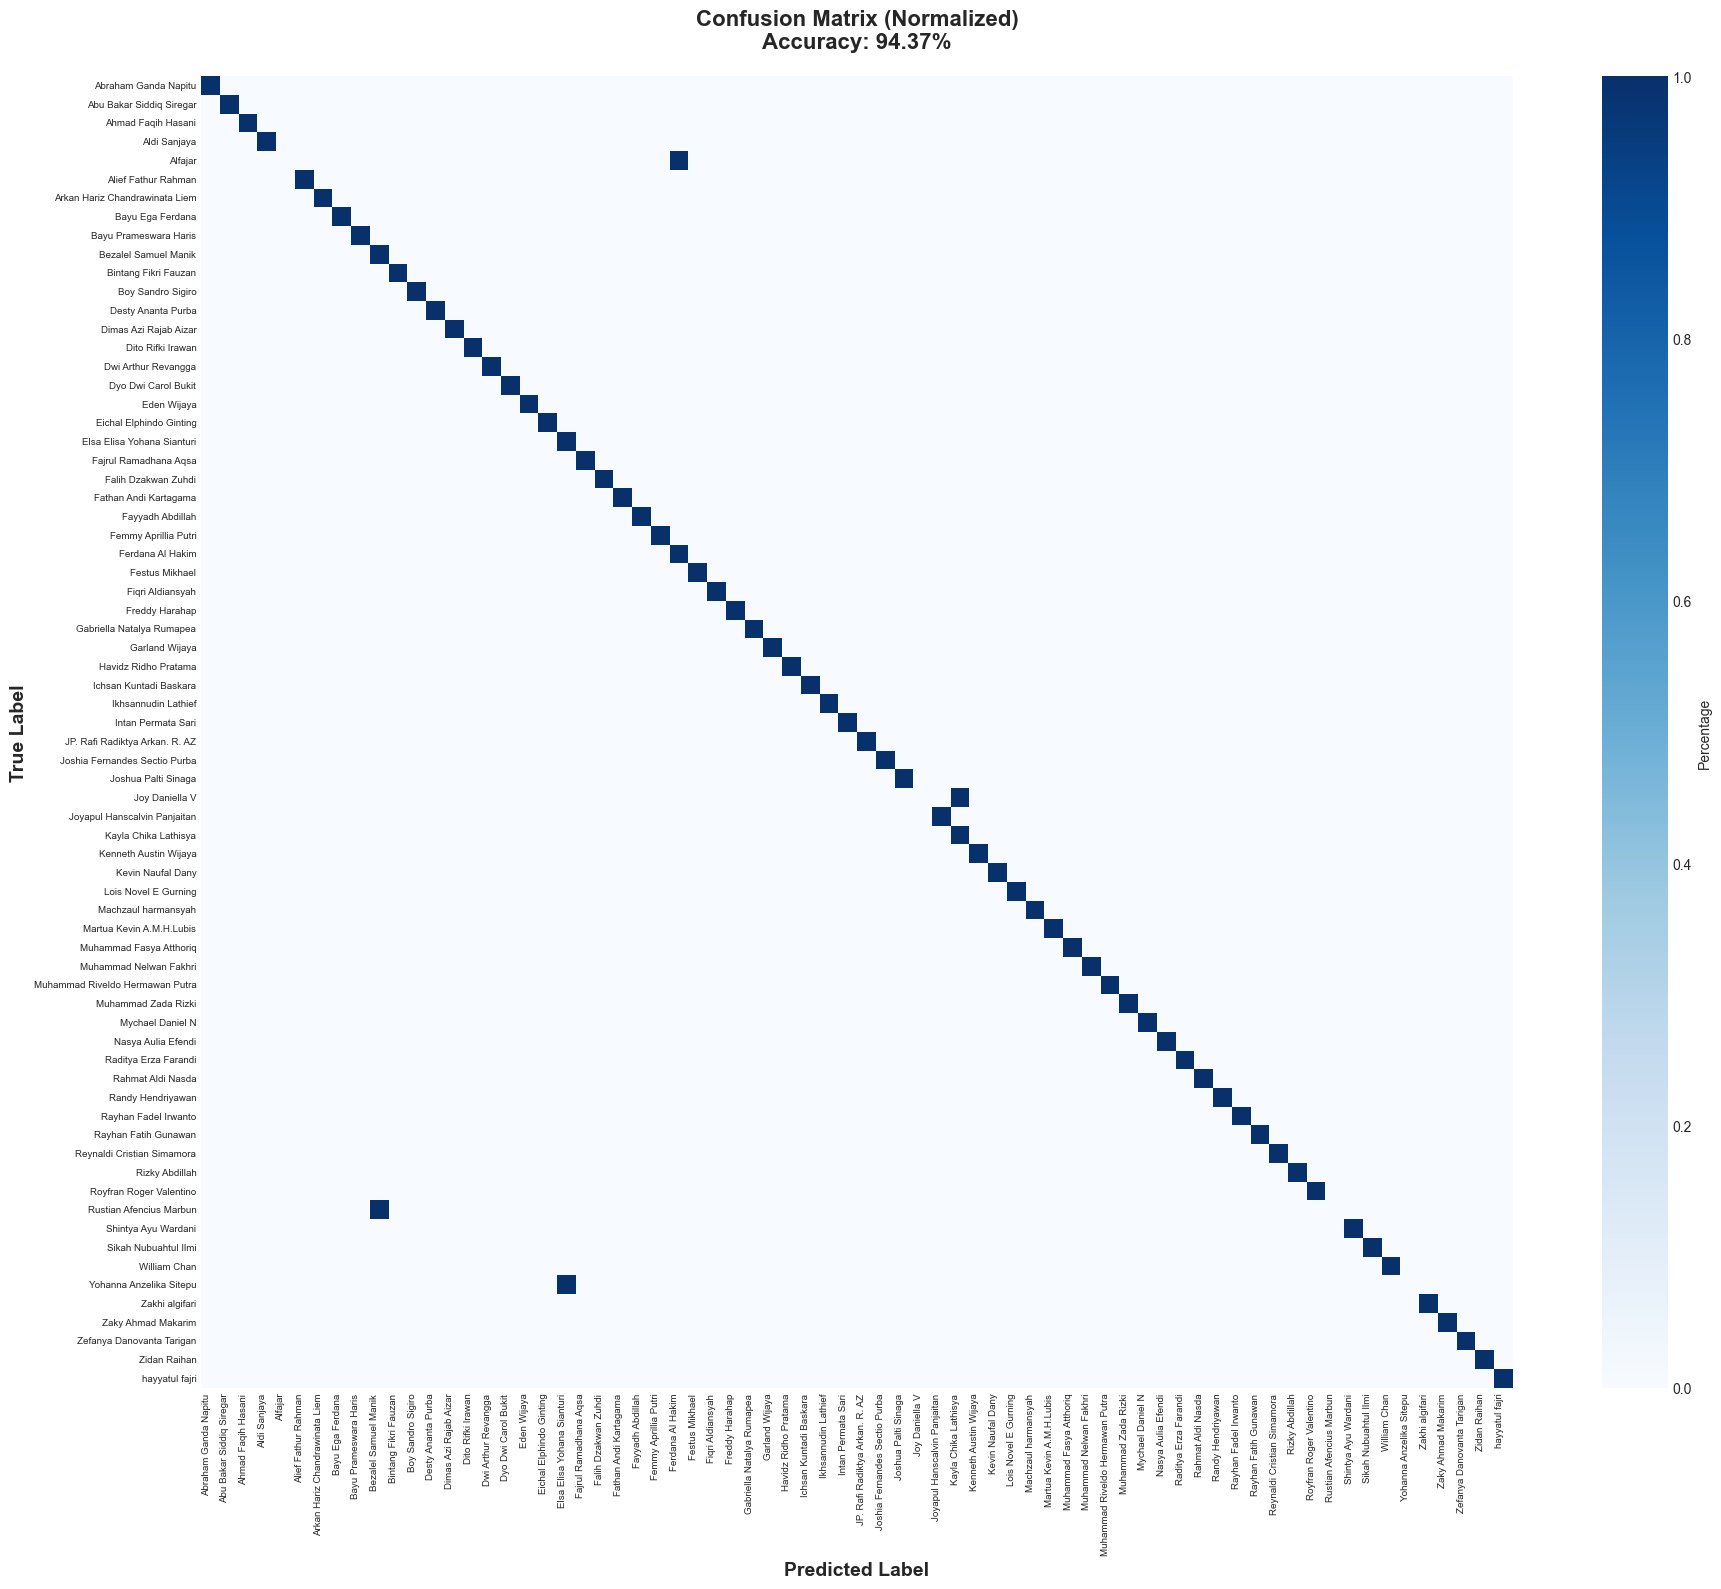

In [11]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(20, 16))

sns.heatmap(
    cm_normalized,
    annot=False,
    fmt='.2%',
    cmap='Blues',
    xticklabels=test_dataset.classes,
    yticklabels=test_dataset.classes,
    cbar_kws={'label': 'Percentage'},
    ax=ax,
    square=True
)

ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax.set_title(f'Confusion Matrix (Normalized)\nAccuracy: {accuracy:.2%}', 
             fontsize=16, fontweight='bold', pad=20)

plt.xticks(rotation=90, ha='right', fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()

# Save figure
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrix saved to: {OUTPUT_DIR / 'confusion_matrix.png'}")

plt.show()

## 8️⃣ Per-Class Accuracy Analysis

In [12]:
# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Create per-class dataframe
per_class_df = pd.DataFrame({
    'Student': test_dataset.classes,
    'Accuracy': per_class_accuracy,
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'F1-Score': per_class_f1,
    'Support': per_class_support,
    'Correct': cm.diagonal().astype(int),
    'Total': cm.sum(axis=1).astype(int)
})

# Sort by accuracy
per_class_df = per_class_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

# Display statistics
print("\n" + "="*60)
print("📈 PER-CLASS STATISTICS")
print("="*60)
print(f"Perfect accuracy (100%): {(per_class_accuracy == 1.0).sum()} students")
print(f"High accuracy (≥90%):    {(per_class_accuracy >= 0.9).sum()} students")
print(f"Medium accuracy (≥70%):  {(per_class_accuracy >= 0.7).sum()} students")
print(f"Low accuracy (<70%):     {(per_class_accuracy < 0.7).sum()} students")
print("="*60)

# Display top 10 and bottom 10
print("\n🏆 TOP 10 STUDENTS (Highest Accuracy):")
print(per_class_df.head(10)[['Student', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Correct', 'Total']].to_string(index=False))

print("\n⚠️ BOTTOM 10 STUDENTS (Lowest Accuracy):")
print(per_class_df.tail(10)[['Student', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Correct', 'Total']].to_string(index=False))

# Save to CSV
per_class_df.to_csv(OUTPUT_DIR / 'per_class_metrics.csv', index=False)
print(f"\n✓ Per-class metrics saved to: {OUTPUT_DIR / 'per_class_metrics.csv'}")


📈 PER-CLASS STATISTICS
Perfect accuracy (100%): 66 students
High accuracy (≥90%):    66 students
Medium accuracy (≥70%):  66 students
Low accuracy (<70%):     4 students

🏆 TOP 10 STUDENTS (Highest Accuracy):
                       Student  Accuracy  Precision  Recall  F1-Score  Correct  Total
          Abraham Ganda Napitu       1.0        1.0     1.0  1.000000        1      1
      Abu Bakar Siddiq Siregar       1.0        1.0     1.0  1.000000        1      1
            Ahmad Faqih Hasani       1.0        1.0     1.0  1.000000        1      1
                  Aldi Sanjaya       1.0        1.0     1.0  1.000000        1      1
           Alief Fathur Rahman       1.0        1.0     1.0  1.000000        1      1
Arkan Hariz Chandrawinata Liem       1.0        1.0     1.0  1.000000        1      1
  Joyapul Hanscalvin Panjaitan       1.0        1.0     1.0  1.000000        1      1
              Bayu Ega Ferdana       1.0        1.0     1.0  1.000000        1      1
         Bayu Pr

## 9️⃣ Per-Class Accuracy Visualization

✓ Per-class accuracy plot saved to: test_results\per_class_accuracy.png


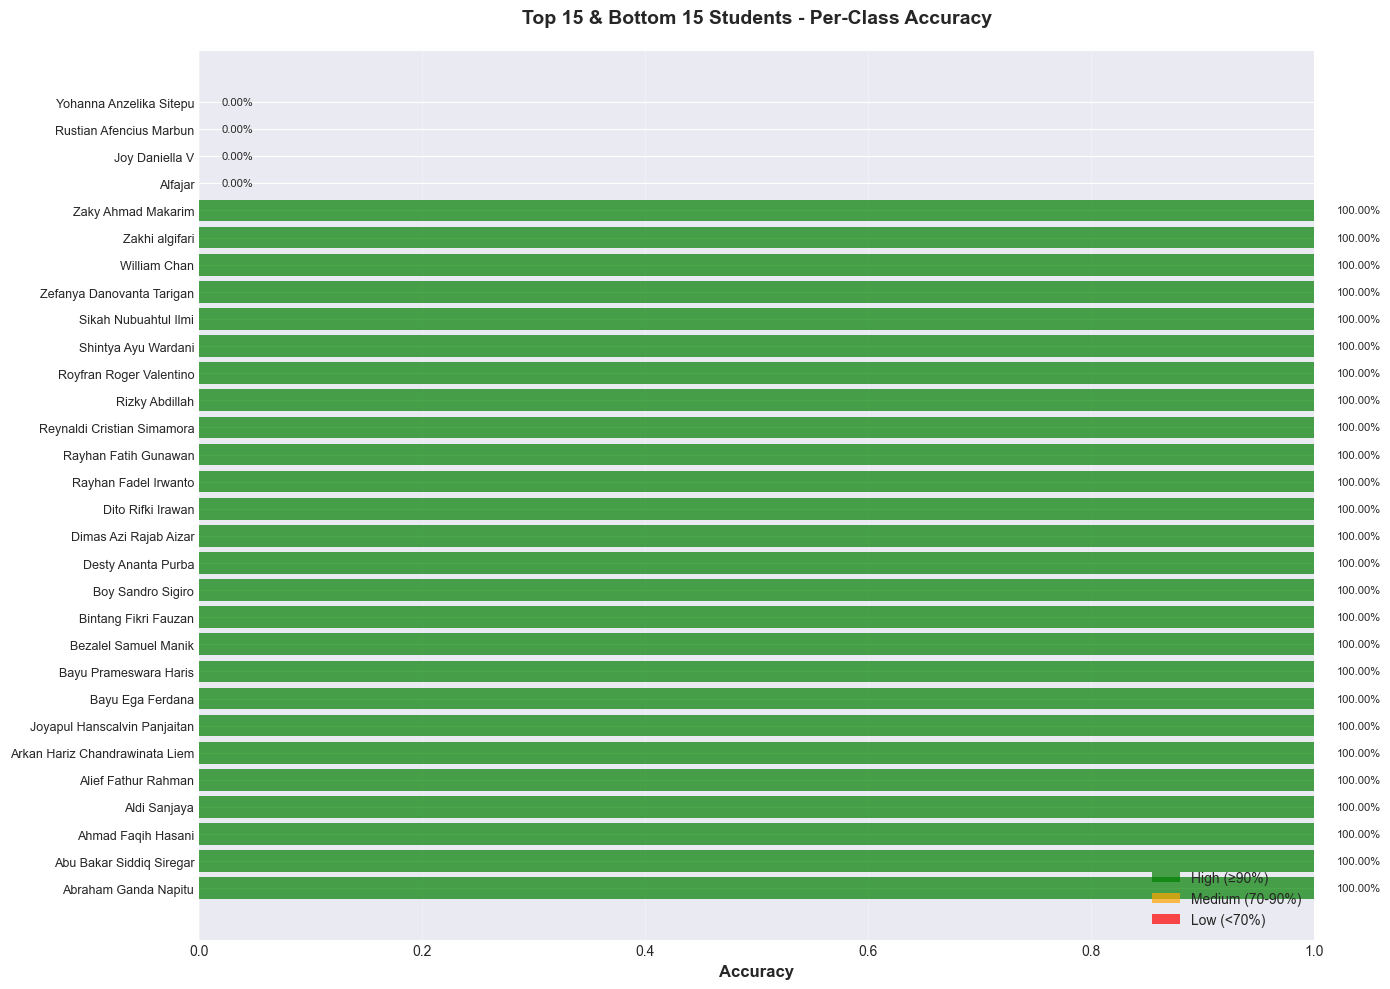

In [13]:
# Plot per-class accuracy (top 15 and bottom 15)
top15 = per_class_df.head(15)
bottom15 = per_class_df.tail(15)
plot_df = pd.concat([top15, bottom15])

fig, ax = plt.subplots(figsize=(14, 10))

# Color coding
colors = ['green' if acc >= 0.9 else 'orange' if acc >= 0.7 else 'red' 
          for acc in plot_df['Accuracy']]

bars = ax.barh(range(len(plot_df)), plot_df['Accuracy'], color=colors, alpha=0.7)
ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels(plot_df['Student'], fontsize=9)
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Top 15 & Bottom 15 Students - Per-Class Accuracy', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 1.0)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, plot_df['Accuracy'])):
    ax.text(acc + 0.02, i, f'{acc:.2%}', va='center', fontsize=8)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='High (≥90%)'),
    Patch(facecolor='orange', alpha=0.7, label='Medium (70-90%)'),
    Patch(facecolor='red', alpha=0.7, label='Low (<70%)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'per_class_accuracy.png', dpi=300, bbox_inches='tight')
print(f"✓ Per-class accuracy plot saved to: {OUTPUT_DIR / 'per_class_accuracy.png'}")
plt.show()

## 🔟 Metrics Bar Chart

✓ Metrics bar chart saved to: test_results\metrics_bar_chart.png


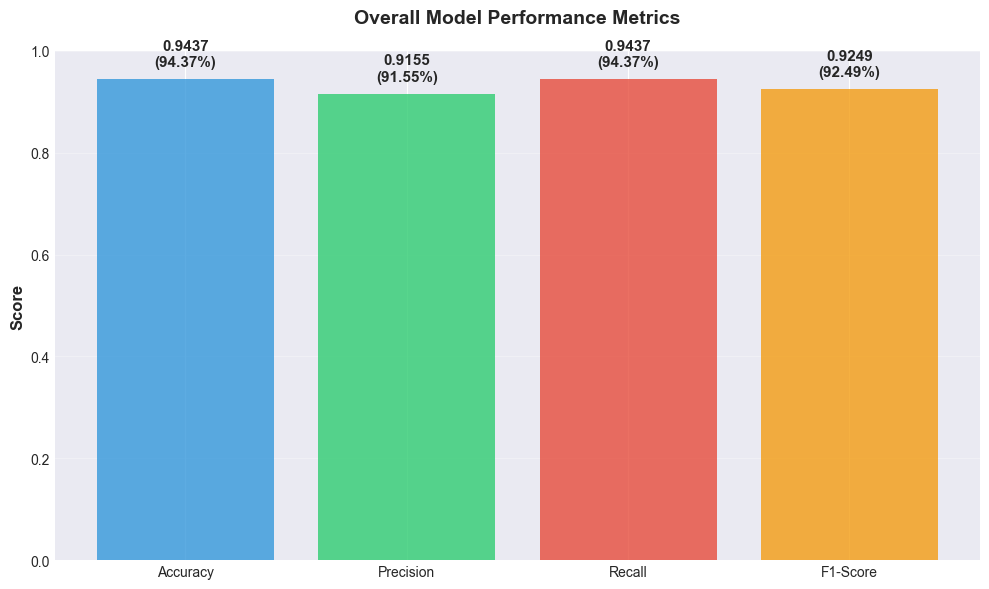

In [14]:
# Plot metrics bar chart
fig, ax = plt.subplots(figsize=(10, 6))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision, recall, f1]

bars = ax.bar(metrics_names, metrics_values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'], alpha=0.8)
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Overall Model Performance Metrics', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value:.4f}\n({value*100:.2f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'metrics_bar_chart.png', dpi=300, bbox_inches='tight')
print(f"✓ Metrics bar chart saved to: {OUTPUT_DIR / 'metrics_bar_chart.png'}")
plt.show()

## 1️⃣1️⃣ Classification Report

In [15]:
# Generate classification report
report = classification_report(
    all_labels, 
    all_preds, 
    target_names=test_dataset.classes,
    zero_division=0
)

print("\n" + "="*60)
print("📄 CLASSIFICATION REPORT")
print("="*60)
print(report)

# Save report
with open(OUTPUT_DIR / 'classification_report.txt', 'w', encoding='utf-8') as f:
    f.write("Classification Report\n")
    f.write("=" * 60 + "\n\n")
    f.write(report)

print(f"✓ Classification report saved to: {OUTPUT_DIR / 'classification_report.txt'}")


📄 CLASSIFICATION REPORT
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       1.00      1.00      1.00         1
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         1
             Ahmad Faqih Hasani       1.00      1.00      1.00         1
                   Aldi Sanjaya       1.00      1.00      1.00         1
                        Alfajar       0.00      0.00      0.00         1
            Alief Fathur Rahman       1.00      1.00      1.00         1
 Arkan Hariz Chandrawinata Liem       1.00      1.00      1.00         1
               Bayu Ega Ferdana       1.00      1.00      1.00         1
          Bayu Prameswara Haris       1.00      1.00      1.00         1
           Bezalel Samuel Manik       0.50      1.00      0.67         1
           Bintang Fikri Fauzan       1.00      1.00      1.00         1
              Boy Sandro Sigiro       1.00      1.00      1.00         1
             Desty Ananta

## 1️⃣2️⃣ Inference Speed Testing

Testing inference speed...



Timing:   0%|          | 0/100 [00:00<?, ?it/s]


⚡ INFERENCE SPEED
Mean time:   23.84 ± 4.95 ms
Min time:    15.48 ms
Max time:    51.34 ms
FPS:         41.9 frames/second

✓ Inference speed plot saved to: test_results\inference_speed.png

✓ Inference speed plot saved to: test_results\inference_speed.png


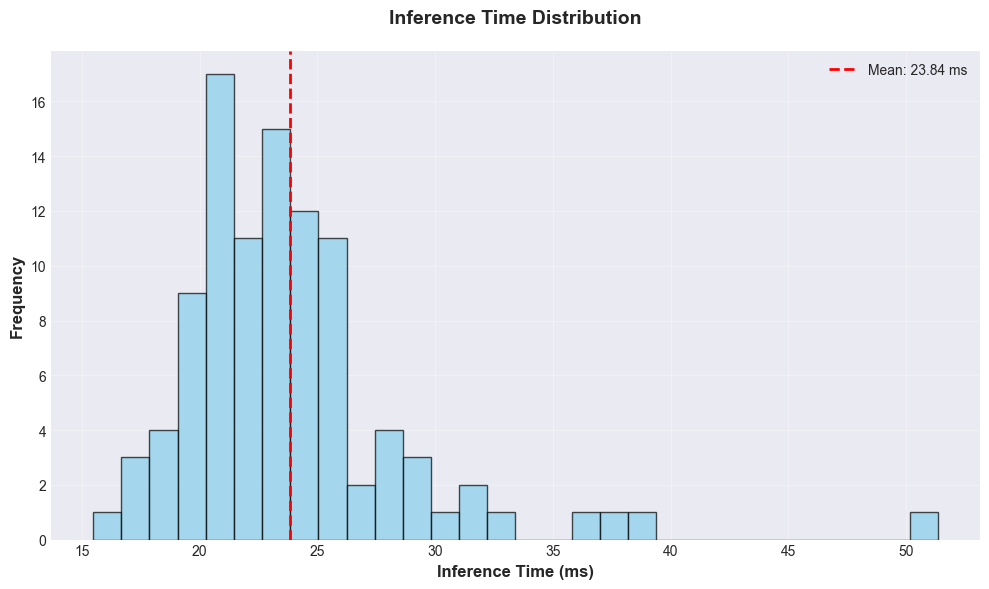

In [17]:
print("Testing inference speed...\n")

# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warmup
for _ in range(10):
    _ = model(dummy_input)

# Measure inference time
num_iterations = 100
times = []

for _ in tqdm(range(num_iterations), desc="Timing"):
    start = time.time()
    with torch.no_grad():
        _ = model(dummy_input)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    times.append((end - start) * 1000)  # Convert to ms

# Calculate statistics
mean_time = np.mean(times)
std_time = np.std(times)
min_time = np.min(times)
max_time = np.max(times)
fps = 1000 / mean_time

print("\n" + "="*60)
print("⚡ INFERENCE SPEED")
print("="*60)
print(f"Mean time:   {mean_time:.2f} ± {std_time:.2f} ms")
print(f"Min time:    {min_time:.2f} ms")
print(f"Max time:    {max_time:.2f} ms")
print(f"FPS:         {fps:.1f} frames/second")
print("="*60)

# Plot inference time distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(times, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax.axvline(mean_time, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_time:.2f} ms')
ax.set_xlabel('Inference Time (ms)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Inference Time Distribution', fontsize=14, fontweight='bold', pad=20)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'inference_speed.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Inference speed plot saved to: {OUTPUT_DIR / 'inference_speed.png'}")
plt.show()

## 1️⃣3️⃣ Save Final Results

In [18]:
# Compile all results
final_results = {
    'model_name': model_name,
    'test_dataset': str(TEST_DIR),
    'num_samples': len(test_dataset),
    'num_classes': len(test_dataset.classes),
    'device': str(device),
    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'top5_accuracy': float(top5_accuracy)
    },
    'inference_speed': {
        'mean_ms': float(mean_time),
        'std_ms': float(std_time),
        'min_ms': float(min_time),
        'max_ms': float(max_time),
        'fps': float(fps)
    },
    'per_class_statistics': {
        'perfect_accuracy_count': int((per_class_accuracy == 1.0).sum()),
        'high_accuracy_count': int((per_class_accuracy >= 0.9).sum()),
        'medium_accuracy_count': int((per_class_accuracy >= 0.7).sum()),
        'low_accuracy_count': int((per_class_accuracy < 0.7).sum())
    }
}

# Save to JSON
with open(OUTPUT_DIR / 'test_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

print("\n" + "="*60)
print("💾 RESULTS SAVED")
print("="*60)
print(f"✓ Test results JSON:     {OUTPUT_DIR / 'test_results.json'}")
print(f"✓ Confusion matrix:      {OUTPUT_DIR / 'confusion_matrix.png'}")
print(f"✓ Per-class accuracy:    {OUTPUT_DIR / 'per_class_accuracy.png'}")
print(f"✓ Per-class metrics CSV: {OUTPUT_DIR / 'per_class_metrics.csv'}")
print(f"✓ Metrics bar chart:     {OUTPUT_DIR / 'metrics_bar_chart.png'}")
print(f"✓ Classification report: {OUTPUT_DIR / 'classification_report.txt'}")
print(f"✓ Inference speed plot:  {OUTPUT_DIR / 'inference_speed.png'}")
print("="*60)


💾 RESULTS SAVED
✓ Test results JSON:     test_results\test_results.json
✓ Confusion matrix:      test_results\confusion_matrix.png
✓ Per-class accuracy:    test_results\per_class_accuracy.png
✓ Per-class metrics CSV: test_results\per_class_metrics.csv
✓ Metrics bar chart:     test_results\metrics_bar_chart.png
✓ Classification report: test_results\classification_report.txt
✓ Inference speed plot:  test_results\inference_speed.png


## 1️⃣4️⃣ Summary Report

In [ ]:
print("\n" + "="*70)
print(" "*20 + "🎯 FINAL TEST SUMMARY" + " "*20)
print("="*70)

print(f"\n📦 Model Information:")
print(f"   Model Name:        {model_name}")
print(f"   Architecture:      CNN (FaceNet + ArcFace)")
print(f"   Input Size:        224×224×3")
print(f"   Number of Classes: {num_classes}")

print(f"\n📊 Test Dataset:")
print(f"   Test Directory:    {TEST_DIR}")
print(f"   Total Samples:     {len(test_dataset)}")
print(f"   Batch Size:        32")

print(f"\n🎯 Performance Metrics:")
print(f"   Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision:         {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:            {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:          {f1:.4f} ({f1*100:.2f}%)")
print(f"   Top-5 Accuracy:    {top5_accuracy:.4f} ({top5_accuracy*100:.2f}%)")

print(f"\n⚡ Inference Performance:")
print(f"   Mean Time:         {mean_time:.2f} ± {std_time:.2f} ms")
print(f"   FPS:               {fps:.1f} frames/second")
print(f"   Device:            {device}")

print(f"\n📈 Per-Class Statistics:")
print(f"   Perfect (100%):    {(per_class_accuracy == 1.0).sum()} students")
print(f"   High (≥90%):       {(per_class_accuracy >= 0.9).sum()} students")
print(f"   Medium (≥70%):     {(per_class_accuracy >= 0.7).sum()} students")
print(f"   Low (<70%):        {(per_class_accuracy < 0.7).sum()} students")

print("\n" + "="*70)
print(" "*25 + "✅ TESTING COMPLETE!" + " "*25)
print("="*70)

# Save summary to text file
with open(OUTPUT_DIR / 'summary_report.txt', 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write(" "*20 + "FINAL TEST SUMMARY" + " "*20 + "\n")
    f.write("="*70 + "\n\n")
    f.write(f"Model Information:\n")
    f.write(f"  Model Name:        {model_name}\n")
    f.write(f"  Architecture:      CNN (FaceNet + ArcFace)\n")
    f.write(f"  Number of Classes: {num_classes}\n\n")
    f.write(f"Performance Metrics:\n")
    f.write(f"  Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)\n")
    f.write(f"  Precision:         {precision:.4f} ({precision*100:.2f}%)\n")
    f.write(f"  Recall:            {recall:.4f} ({recall*100:.2f}%)\n")
    f.write(f"  F1-Score:          {f1:.4f} ({f1*100:.2f}%)\n")
    f.write(f"  Top-5 Accuracy:    {top5_accuracy:.4f} ({top5_accuracy*100:.2f}%)\n\n")
    f.write(f"Inference Performance:\n")
    f.write(f"  Mean Time:         {mean_time:.2f} ± {std_time:.2f} ms\n")
    f.write(f"  FPS:               {fps:.1f} frames/second\n")

print(f"\n✓ Summary report saved to: {OUTPUT_DIR / 'summary_report.txt'}")